实现一个单机简化版的 Top-k MoE-FFN，带 capacity 管理。不含分布式通信，但保持真实的数据流：route -> dispatch -> expert -> combine。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TopKRouter(nn.Module):
    def __init__(self, d_model, n_expert, k=2, lb_coef=0.01):
        super().__init__()
        self.proj = nn.Linear(d_model, n_expert, bias=False)
        self.n_expert = n_expert
        self.k = k
        self.lb_coef = lb_coef
        
    def forward(self, x):
        B, T, D = x.shape
        logits = self.proj(x) 
        B, T, E = logits.shape

        gate = F.softmax(logits, dim=-1)
        topk_val, topk_idx = torch.topk(gate, k=self.k, dim=-1)
        combine = topk_val / (topk_val.sum(dim=-1, keepdim=True) + 1e-9) # (B, T, k)
        
        expert_prob_mean = gate.mean(dim=(0,1))
        lb_loss = self.lb_coef * (expert_prob_mean * self.n_expert).var()
        return topk_idx, combine, lb_loss

In [2]:
router = TopKRouter(128, 3, k=2)
x = torch.randn(2, 10, 128)
topk_idx, combine, lb_loss = router(x)
topk_idx, combine, lb_loss.detach()

(tensor([[[2, 0],
          [0, 1],
          [2, 0],
          [0, 1],
          [1, 2],
          [0, 1],
          [1, 0],
          [1, 0],
          [2, 0],
          [1, 0]],
 
         [[1, 2],
          [0, 2],
          [0, 1],
          [1, 2],
          [2, 1],
          [1, 0],
          [1, 2],
          [2, 1],
          [0, 2],
          [1, 0]]]),
 tensor([[[0.7276, 0.2724],
          [0.5056, 0.4944],
          [0.7670, 0.2330],
          [0.6169, 0.3831],
          [0.5569, 0.4431],
          [0.6603, 0.3397],
          [0.5663, 0.4337],
          [0.5104, 0.4896],
          [0.5983, 0.4017],
          [0.6073, 0.3927]],
 
         [[0.7937, 0.2063],
          [0.7699, 0.2301],
          [0.5613, 0.4387],
          [0.5443, 0.4557],
          [0.6573, 0.3427],
          [0.7773, 0.2227],
          [0.5107, 0.4893],
          [0.6470, 0.3530],
          [0.7049, 0.2951],
          [0.5109, 0.4891]]], grad_fn=<DivBackward0>),
 tensor(3.9716e-05))

In [3]:
class ExpertFFN(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.up = nn.Linear(d_model, d_ff, bias=False)
        self.down = nn.Linear(d_ff, d_model, bias=False)

    def forward(self, x):
        x = self.dropout(x)
        out = self.down(F.gelu(self.up(x)))
        return out

In [4]:
expert_fnn = ExpertFFN(128, 512)
x = torch.randn(2, 10, 128)
expert_fnn(x).shape

torch.Size([2, 10, 128])

In [5]:
router = TopKRouter(128, 32, k=2, lb_coef=0.02)
experts = nn.ModuleList([ExpertFFN(128, 512) for _ in range(32)])
2 / 32

0.0625

In [33]:
x = torch.randn(64, 100, 128)
W = torch.randn(128, 128)
y = x @ W
y.shape

torch.Size([64, 100, 128])

In [6]:
B, T, C = x.shape
device = x.device

In [7]:
topk_idx, combine, lb_loss = router(x) # (B, T, k), (B, T, k), scalar
lb_loss

tensor(3.2025e-06, grad_fn=<MulBackward0>)

In [8]:
x_flat = x.reshape(B * T, -1)
idx_flat = topk_idx.reshape(B * T, -1)
w_flat = combine.reshape(B * T, -1)

capacity 计算。每个专家最多接收 tokens_per_exp * capacity_factor 个 token。统计每个专家被路由到的 token 总数（按 top-k 计数）。

In [9]:
capacity_factor = 1.05

with torch.no_grad():
    counts = torch.zeros(32, device=device, dtype=torch.int32)
    for e in range(32):
        counts[e] = (idx_flat == e).sum()

    expected = (B * T) * (2 / 32)
    capacity = int(capacity_factor * expected)

counts, capacity, (counts > capacity)

(tensor([402, 380, 455, 449, 405, 382, 327, 376, 348, 487, 410, 445, 375, 455,
         359, 432, 411, 456, 407, 360, 377, 390, 355, 354, 449, 417, 331, 415,
         342, 373, 460, 416], dtype=torch.int32),
 420,
 tensor([False, False,  True,  True, False, False, False, False, False,  True,
         False,  True, False,  True, False,  True, False,  True, False, False,
         False, False, False, False,  True, False, False, False, False, False,
          True, False]))

(np.float64(-0.5), np.float64(31.5), np.float64(0.5), np.float64(-0.5))

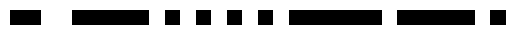

In [10]:
import matplotlib.pyplot as plt
mask = counts > capacity
mask = mask.unsqueeze(1).T
plt.imshow(mask, cmap="cubehelix")
plt.axis('off')

接下来，为每个专家分配一个缓冲区；实际分布式里会做 all-to-all，且按 capacity pack。

简化打包，溢出的丢弃；真实实现可 reroute/overflow 策略。

In [15]:
expert_inputs = [[] for _ in range(32)]
expert_weights = [[] for _ in range(32)]
expert_pos = [[] for _ in range(32)]
capacity_used = [0 for _ in range(32)]

for n in range(B * T):
    for k in range(2):
        e = int(idx_flat[n, k])
        if capacity_used[e] < capacity:
            expert_inputs[e].append(x_flat[n:n+1, :])  # [1, D]
            expert_weights[e].append(w_flat[n, k:k+1]) # [1]
            expert_pos[e].append((n, k))
            capacity_used[e] += 1
        else:
            pass # here we simplified

print(torch.tensor(capacity_used))
print("overflowed tokens:", B * T * 2 - sum(capacity_used))

tensor([402, 380, 420, 420, 405, 382, 327, 376, 348, 420, 410, 420, 375, 420,
        359, 420, 411, 420, 407, 360, 377, 390, 355, 354, 420, 417, 331, 415,
        342, 373, 420, 416])
overflowed tokens: 308


In [16]:
out_flat = torch.zeros(B*T, C, dtype=torch.float64, device=device)
for e in range(32):
    if len(expert_inputs[e]) == 0:
        continue
    inp = torch.cat(expert_inputs[e], dim=0) # [s_e, C]
    wts = torch.cat(expert_weights[e], dim=0) # [s_e, 1]
    y = experts[e](inp) # [s_e, C]
    for i, (n, k) in enumerate(expert_pos[e]):
        out_flat[n] += wts[i] * y[i]

out = out_flat.reshape(B, T, C)
aux_loss = lb_loss
out.shape, aux_loss

(torch.Size([64, 100, 128]), tensor(3.2025e-06, grad_fn=<MulBackward0>))

In [19]:
y = torch.randn(64, 100, 128).detach()
loss = ((out - y) ** 2).mean() + aux_loss
loss.backward()

In [25]:
class MoEFFN(nn.Module):
    def __init__(self, d_model, d_ff, n_expert=32, k=2, capacity_factor=1.25, lb_coef=0.01):
        super().__init__()
        self.router = TopKRouter(d_model, n_expert, k=k, lb_coef=lb_coef)
        self.experts = nn.ModuleList([ExpertFFN(d_model, d_ff) for _ in range(n_expert)])
        self.n_expert = n_expert
        self.k = k
        self.capacity_factor = capacity_factor

    def forward(self, x):
        B, T, D = x.shape
        device = x.device

        topk_idx, combine, lb_loss = self.router(x)  # [B,T,k], [B,T,k], scalar
        N = B * T
        x_flat = x.reshape(N, D)                      # [N, D]
        idx_flat = topk_idx.reshape(N, self.k)        # [N, k]
        w_flat = combine.reshape(N, self.k)           # [N, k]

        with torch.no_grad():
            counts = torch.zeros(self.n_expert, device=device, dtype=torch.int32)
            for e in range(self.n_expert):
                counts[e] = (idx_flat == e).sum()

            expected = (N * self.k) / self.n_expert
            capacity = int(self.capacity_factor * expected)

        expert_inputs = [ [] for _ in range(self.n_expert) ]
        expert_weights = [ [] for _ in range(self.n_expert) ]
        expert_pos = [ [] for _ in range(self.n_expert) ]

        cap_used = [0] * self.n_expert
        for n in range(N):
            for kk in range(self.k):
                e = int(idx_flat[n, kk])
                if cap_used[e] < capacity:
                    expert_inputs[e].append(x_flat[n:n+1, :])   # [1, D]
                    expert_weights[e].append(w_flat[n, kk:kk+1])# [1]
                    expert_pos[e].append((n, kk))
                    cap_used[e] += 1
                else:
                    pass

        out_flat = torch.zeros(N, D, device=device)
        for e in range(self.n_expert):
            if len(expert_inputs[e]) == 0:
                continue
            inp = torch.cat(expert_inputs[e], dim=0)           # [S_e, D]
            wts = torch.cat(expert_weights[e], dim=0)          # [S_e, 1]
            y = self.experts[e](inp)                           # [S_e, D]
            for i, (n, kk) in enumerate(expert_pos[e]):
                out_flat[n] += wts[i] * y[i]

        out = out_flat.view(B, T, D)
        aux_loss = lb_loss
        return out, aux_loss

In [36]:
moe = MoEFFN(d_model=128, d_ff=512, n_expert=2, k=1, capacity_factor=1.2)
moe.train()

for epoch in range(10):
    out, aux = moe(x)
    loss = ((out - y) ** 2).mean() + aux
    loss.backward()
    print("loss:", loss.detach())

loss: tensor(126.8601)
loss: tensor(126.8588)
loss: tensor(126.8575)
loss: tensor(126.8587)
loss: tensor(126.8586)
loss: tensor(126.8576)
loss: tensor(126.8565)
loss: tensor(126.8541)
loss: tensor(126.8572)
loss: tensor(126.8577)
